# Exploración de tópicos en el campo de los Proceso Costeros.
---

Autores:
* Giovanny Alejandro Cuervo Londoño


In [ ]:
# Instalamos los paquetes necesarios
!pip install selenium
!apt-get update 
!apt install chromium-chromedriver
!pip install fake_useragent
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 995 kB 9.5 MB/s 
     |████████████████████████████████| 140 kB 48.9 MB/s 
     |████████████████████████████████| 384 kB 48.2 MB/s 
     |████████████████████████████████| 58 kB 6.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.12 which is incompatible.
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.downlo

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
# Montamos nuestro google drive
from google.colab import drive
drive.mount('/content/drive')
dir = "/content/drive/MyDrive/Python/PLN/PLN UNAL ing/Proyecto/"

Mounted at /content/drive


## 1. Entendimiento del problema
---
Agruegue una explicación del problema que trata de solucionar. Intente dar respuesta a las siguientes preguntas:

* De dónde vienen los datos?
> Los fueron extraídos de <a href="https://www.sciencedirect.com/">Science Direct</a> por medio de herramientas de web scraping.

* Qué tipo de datos tenemos? (recuerde que el conjunto de datos debe ser enfocado a texto, pero puede que tenga algunas variables o información adicional que pueda ser de utilidad)
> Los datos utilizados en este proyecto son de tipo *string* o texto. Estos corresponden a los *abstratcs* de 1000 artículos tomados de diferentes revistas científicas registradas en Elsevier. 

* En qué formato están los datos?
> Originalmente los datos estaban en formato *html*, dado que se extrajeron de la página web mencionada. 

* Cuál es el objetivo de este proyecto?
> El objetivo de este proyecto es explorar los tópicos más relevantes en el campo de la Oceanografía de costas, aplicando un el **modelo Latent Dirichlet Allocation**. 

* Quiénes se beneficiarían del producto?
> Los principales beneficiarios serían personas del ámbito académico que se encuentren interesados en profundizar o proponer nuevas líneas de conocimiento en el campo de la oceanografía costera.

## 2. Web scraping
---

Implemente las funciones necesarias para extraer la información de recursos como: web, archivos planos, csv, bases de datos, entre otros.

**Adquisición e integración de datos**

In [ ]:
# Timepo de espera con una Distribución de probabilidad lognormal
def distriProb_lognorm():
  pdf = np.random.lognormal(mean=2.0, sigma=0.5, size=(1))
  if pdf<3  or pdf>7:
    pdf=np.random.randint(3,6)
  return float(pdf)

In [ ]:
# Fake user agent
ua = UserAgent()
user_agent = ua.random
print(user_agent)

Mozilla/5.0 (Windows NT 6.2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/28.0.1464.0 Safari/537.36


In [ ]:
# Define el opciones del nevegador
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('--disable-blink-features=AutomationControlled')
options.add_experimental_option('useAutomationExtension', False)
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_argument(f'user-agent={user_agent}')
# Definimos un navegador
driver =  webdriver.Chrome('chromedriver',options=options)
webpage_target = 'https://www.sciencedirect.com/'

# Colocamos el link de la pagina donde queremos hacer la busqueda
try:
    driver.get(webpage_target)
    time.sleep(distriProb_lognorm())
except:
    print('Hubo un error de conexion intentando de nuevo...')
    time.sleep(distriProb_lognorm())
    driver.refresh()
    driver.get(webpage_target)
print(driver)

<selenium.webdriver.chrome.webdriver.WebDriver (session="a1a1853c22df18cbc184be8669c8e833")>


In [ ]:
# Enviamos un query de busqueda a la barra de busqueda
search_box_id = 'qs-searchbox-input'
query = 'Coastal processes'
search_box = driver.find_element(By.ID, search_box_id)
search_box.send_keys(query)
search_box.send_keys(Keys.RETURN) #click enter

# Filtramos los resultados por los que corresponden a reviewa
try:
    time.sleep(distriProb_lognorm())
    reviews = driver.find_element(By.ID, "articleTypes-REV")
    driver.execute_script("arguments[0].click();", reviews)
except:
    print('Hubo un error de conexion intentando de nuevo...')
    time.sleep(10)
    driver.refresh()
    reviews = driver.find_element(By.ID, "articleTypes-REV")
    driver.execute_script("arguments[0].click();", reviews)

# Definimos 100 articulos por pagina
time.sleep(distriProb_lognorm())
xpath_100 = "//a[@class='anchor' and @data-aa-name='srp-100-results-per-page']"
first_100 = driver.find_element(By.XPATH, xpath_100)
driver.execute_script("arguments[0].click();", first_100)

# Extreamos el html
time.sleep(distriProb_lognorm())
soup = BeautifulSoup(driver.page_source, 'html.parser')
art_html = soup.find_all('a', 'anchor result-list-title-link u-font-serif text-s anchor-default', 'rev')
link_list = [link.get('href') for link in art_html]

# Extrae la cantidad de paginas de resultados de busqueda
html_pages = soup.find_all('ol', id='srp-pagination')
N = int(re.findall(r"(?<=of) \d+", str(html_pages))[0])
print(f'Numero de paginas {N}')

Numero de paginas 10


In [ ]:
# Itera sobre cada pagina de los resultados de busqueda
for _ in range(N-1):
    # Siguiente pagina
    time.sleep(distriProb_lognorm())
    xpath_next = "//a[@class='anchor' and @data-aa-name='srp-next-page']"
    next_100 = driver.find_element(By.XPATH, xpath_next)
    driver.execute_script("arguments[0].click();", next_100)

    # Extreamos el html
    time.sleep(distriProb_lognorm())
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    art_html = soup.find_all('a', 'anchor result-list-title-link u-font-serif text-s anchor-default', 'rev')
    
    # Extreamos el link del html
    next_link_list = [link.get('href') for link in art_html]
    
    # Se añade a una lista
    link_list.extend(next_link_list)
    print(len(link_list))

# Creamos un DataFrame para almacenar los link de los articulos
df = pd.DataFrame({'link': link_list})
df['link'] = df['link'].map(lambda link: 'https://www.sciencedirect.com'+link)
df.head()

200
300
400
500
600
700
800
900
1000


,link
0,https://www.sciencedirect.com/science/article/...
1,https://www.sciencedirect.com/science/article/...
2,https://www.sciencedirect.com/science/article/...
3,https://www.sciencedirect.com/science/article/...
4,https://www.sciencedirect.com/science/article/...


In [ ]:
# Visualizamos los ultimos 5 articulos
df.tail()

,link
995,https://www.sciencedirect.com/science/article/...
996,https://www.sciencedirect.com/science/article/...
997,https://www.sciencedirect.com/science/article/...
998,https://www.sciencedirect.com/science/article/...
999,https://www.sciencedirect.com/science/article/...


In [ ]:
# Extraemos los abstracts uno por uno 
# Definimos listas de almacenamiento de los datos extraer
abstracts = []
titles = []
iter = 0

# Iteramos en cada uno de los link de los articulos
for link in df['link']:
  # Contador de iteraciones
  iter += 1
  print(f'iteracion {iter}')
  # Navegamos hasta la pagina de interes
  driver.get(link)
  time.sleep(distriProb_lognorm())
  # Obtenemos el html de la pagina
  soup = BeautifulSoup(driver.page_source, 'html.parser')
  # Extraemos el titulo
  html_title = soup.find_all('span', 'title-text')
  # Removemos caracteres especiales del html y espacios
  title_text = re.sub(r"\<[^>]+>", ' ', str(html_title))
  title_text = re.sub(r"\s+", ' ', str(title_text))
  print(title_text)
  # Agregamos el titulo a l alista de titulos
  titles.append(title_text)
  print(len(titles)
  # Removemos caracteres especiales y dos stop-words del html
  rexp = re.compile(r"\<[^>]+>|Summary|Abstract|•")
  # Extraemos todos los abstracts
  html_abstract = soup.find_all('div', class_=re.compile("(abstract author|abstract author xh-highlight)"))
  # Limpiamos un poco el texto 
  abstract_text = re.sub(rexp, ' ', str(html_abstract))
  abstract_text = re.sub(r'\s+', ' ', str(abstract_text))
  # Unimos todos los tokens en un string
  abstract_text = ''.join(abstract_text)
  print(abstract_text)
  # Agregamos todos los abstracts a una lista
  abstracts.append(abstract_text)
  print(len(abstracts))
# Cerramos nuestro navegador
time.sleep(distriProb_lognorm())
driver.close()

iteracion 1
[ Advances in the study of coastal processes in the continental Colombian Caribbean coast ]
1
[ This paper reviews the state of scientific knowledge on coastal processes in the continental Colombian Caribbean Coast. The covered topics include the research advances on estuarine dynamics , wave climate, and coastline evolution in the region. This review aims to offer an updated baseline on the topics and sites that have been more explored by coastal scientists and those who need more efforts in short- to mid-term. The extensive analysis of peer-reviewed literature carried out here shows that river mouths are the most studied coastal systems in the region, together with the coastal sectors near the largest cities. On the contrary, national parks and pristine areas with high environmental value are barely studied. Finally, a vision from the author’s perspective on important physical-coastal and transdisciplinary issues to be addressed in the upcoming years is presented. ]
1
ite

In [ ]:
# Agregamos dos columnas nuevas al df
df['Titles'] = titles
df['Abstracts'] = abstracts
df.to_csv(dir+'abstract_pln.csv')

## 2. Carga de datos
---

Implemente las funciones necesarias para cargar la información en dependencia de su procedencia (web, archivos planos, csv, bases de datos, entre otros).

In [ ]:
# Cargamos los datos como un dataframe
df = pd.read_csv(dir+'abstract_pln.csv')
df

,Unnamed: 0,link,Titles,Abstracts
0,0,https://www.sciencedirect.com/science/article/...,[ Advances in the study of coastal processes i...,[ This paper reviews the state of scientific k...
1,1,https://www.sciencedirect.com/science/article/...,[ Seabird influence on ecological processes in...,[ Highlights Seabirds contribute to inter-habi...
2,2,https://www.sciencedirect.com/science/article/...,[ Process-based indicators to assess storm ind...,[ Storms are responsible for several hazards (...
3,3,https://www.sciencedirect.com/science/article/...,[ Historical antecedents and local governance ...,[ Brazil has a very big coastal zone of approx...
4,4,https://www.sciencedirect.com/science/article/...,[ Hydrochemical and isotopical evidence of gro...,[ Salinization in coastal areas of the provinc...
...,...,...,...,...
995,995,https://www.sciencedirect.com/science/article/...,[ Is there a win–win scenario for marine natur...,[ A statutory two hundred and six square kilom...
996,996,https://www.sciencedirect.com/science/article/...,[ High-resolution sequence stratigraphy of cla...,[ Highlights The features of clastic shelf res...
997,997,https://www.sciencedirect.com/science/article/...,[ Microbial methane emissions from the non-met...,[ Highlights Methane production is not limited...
998,998,https://www.sciencedirect.com/science/article/...,[ The North American hydrologic cycle through ...,[ While the climate evolution of North America...


In [ ]:
# Definimos una funcion para buscar palabras en la columna de abstracts
def find_word(word):
  idx = df['Abstracts'].apply(lambda x: re.match(fr'.+{word}.+', x)).values.nonzero()[0]
  mask = df.index.isin(list(idx))
  return df.loc[mask]

In [ ]:
# Buscamos la palabra en el df
find_word('SGD')

,Unnamed: 0,link,Titles,Abstracts
250,250,https://www.sciencedirect.com/science/article/...,[ Quantifying submarine groundwater discharge ...,[ Submarine groundwater discharge (SGD) is now...
314,314,https://www.sciencedirect.com/science/article/...,[ Submarine groundwater discharge investigatio...,[ Submarine groundwater discharge (SGD) in coa...
323,323,https://www.sciencedirect.com/science/article/...,[ The social implications of Submarine Groundw...,[ Submarine Groundwater Discharge (SGD) is rec...
348,348,https://www.sciencedirect.com/science/article/...,[ Radium isotopes as submarine groundwater dis...,[ Submarine groundwater discharge (SGD) is now...
542,542,https://www.sciencedirect.com/science/article/...,[ Linkages between submarine groundwater syste...,[ Submarine groundwater discharge (SGD) has be...
555,555,https://www.sciencedirect.com/science/article/...,[ Societal use of fresh submarine groundwater ...,[ Terrestrial groundwater discharging directly...
568,568,https://www.sciencedirect.com/science/article/...,[ Chapter 5 Uranium- and Thorium-Series Nuclid...,[ Publisher A number of U- and Th-series isoto...


In [ ]:
# Creamos nuestro corpus
corpus = df['Abstracts'].to_list()

## 3. Preprocesamiento
---

Se definió una función para preprocesar los *abstracts* de cada artículo aplicando las siguientes operaciones:

* Eliminar caracteres especiales con regex.
* Eliminar tildes.
* Eliminar stopwords.
* Eliminar palabras de una longitud mínima.

In [ ]:
# Definimos el tokenizador
wpt = nltk.WordPunctTokenizer()
# Definimos las stopwords
nltk.download("stopwords")
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(['review', 'highlight', 'highlights', 'research', 'study', 'studies', 'also'])

# Definimos el preprocesamiento
def preprocess(doc):
    # Se eliminan caracteres especiales
    doc = re.sub(r'[^a-zA-Z\s]', '', doc)
    # Se convierten los téxtos a minúsculas
    doc = doc.lower().strip()
    tokens = wpt.tokenize(doc)
    # Se eliminan las stopwords
    tokens = [token for token in tokens
              if token not in stop_words and len(token) > 2]
    # Retornamos una versión filtrada del texto
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Preprocesamos el texto
norm_corpus = list(map(preprocess, corpus))
norm_corpus[0]

'paper reviews state scientific knowledge coastal processes continental colombian caribbean coast covered topics include advances estuarine dynamics wave climate coastline evolution region aims offer updated baseline topics sites explored coastal scientists need efforts short midterm extensive analysis peerreviewed literature carried shows river mouths studied coastal systems region together coastal sectors near largest cities contrary national parks pristine areas high environmental value barely studied finally vision authors perspective important physicalcoastal transdisciplinary issues addressed upcoming years presented'

**Análisis exploratorio de datos**

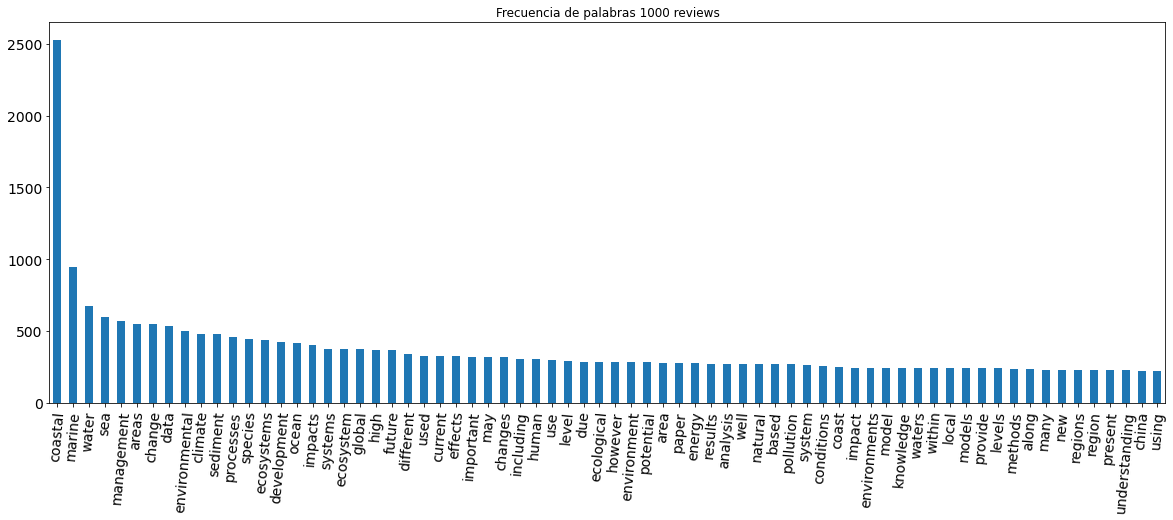

In [ ]:
# Definimos el tokenizador
tokenizer = nltk.WordPunctTokenizer()
# Toquenizamos por palabra
word_tokens = tokenizer.tokenize(' '.join(norm_corpus))
# Creamos un grafico de frecuencias de palabras
frec_words = FreqDist(word_tokens)
fig = plt.figure(figsize =(20, 7))
pd.Series(dict(frec_words)).sort_values(ascending=False)[:70].plot(kind='bar', rot=85, fontsize=14, 
                                                                 title='Frecuencia de palabras 1000 reviews');

Se observa que los términos más frecuentes son: *coastal, marine, water, sea, management, etc.*

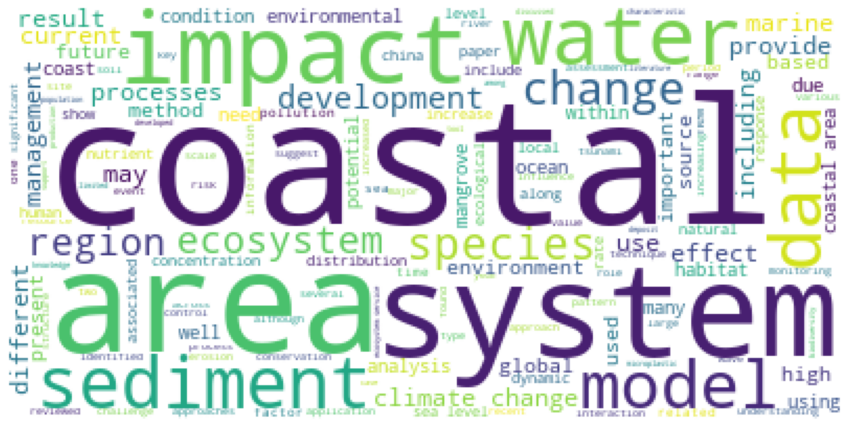

In [ ]:
# Unimos el corpus en un string
long_string = ','.join(norm_corpus)
# Creamos un objeto wordcloud
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generamos una wordcloud
wordcloud = wordcloud.generate(long_string)
# Visualizamos el wordcloud
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

En la nube de palabras se observa que los términos más frecuentes presentan un mayor tamaño respecto a los demás.

## 4. Extracción de Características
---

Se definió una función que generara una matriz de bolsa de documentos (vector de características a nivel documento).

In [ ]:
# Matriz de bolsa de documentos
def feature_extraction(corpus):
    bow = CountVectorizer(
        max_df=0.5
        )
    bow.fit(corpus)
    X_bow = bow.transform(corpus).toarray()
    return X_bow, bow 

In [ ]:
# Bolsa de palabras
X_bow, bow = feature_extraction(norm_corpus)
X_bow.shape

(1000, 15335)

## 5. Modelamiento
---

Para el objetivo de este proyecto se seleccionó el modelo de **Latent Dirichlet Allocation** dado que este permite explorar un número definido de tópicos para finalmente hallar los tópicos más relevantes dentro de la oceanografía costera.


In [ ]:
# Se define 10 topicos a explorar
topics = 10
# Definimos una funcion de entrenamiento
def training(data, topics):
    lda = LDA(n_components=topics, n_jobs=-1, random_state=0)
    lda.fit(X_bow)
    return lda

In [ ]:
# Entrenamos el modelo
lda = training(X_bow, topics)
lda

LatentDirichletAllocation(n_jobs=-1, random_state=0)

In [ ]:
# Listamos los topicos encontrados junto con los palabras mas fecuentes
terms = bow.get_feature_names()
for i, comp in enumerate(lda.components_):
    # Juntamos los términos con cada uno de los valores en la matriz V
    terms_comp = zip(terms, comp)
    # Ordenamos los términos de acuerdo al resultado de LSA
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    # Mostramos los términos más importantes en cada tópico
    print("Tópico {}: {}".format(i," ".join(list(map(lambda x:x[0], sorted_terms)))))

Tópico 0: data marine used monitoring methods development systems knowledge spatial use
Tópico 1: water sea waters upwelling shelf flow high sediment observed nio
Tópico 2: sea energy level current tidal climate wave coast change system
Tópico 3: sediment tsunami deposits sealevel processes beach shoreline beaches sea tsunamis
Tópico 4: management change climate marine ecosystems impacts ecosystem species areas ecological
Tópico 5: subduction continental rocks model cretaceous area south magmatic results late
Tópico 6: marine metal ecosystem soil data water land services ecosystems antarctic
Tópico 7: fish water oil marine species development connectivity ocean ecosystems fisheries
Tópico 8: carbon sediment ocean energy areas global high organic sediments river
Tópico 9: marine environmental pollution water environment areas pollutants sediments methods microplastics


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


**Visualización de resultados**

In [ ]:
X_topics = lda.transform(X_bow)
# Utilizamos TSNE para visualizar el espacio de los tópicos
tsne = TSNE(
        n_components=2,
        random_state=0,
        n_iter=1000,
        perplexity=2,
        verbose=1
        )
T = tsne.fit_transform(X_topics)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.003s...
[t-SNE] Computed neighbors for 1000 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.401794
[t-SNE] KL divergence after 1000 iterations: 0.490301


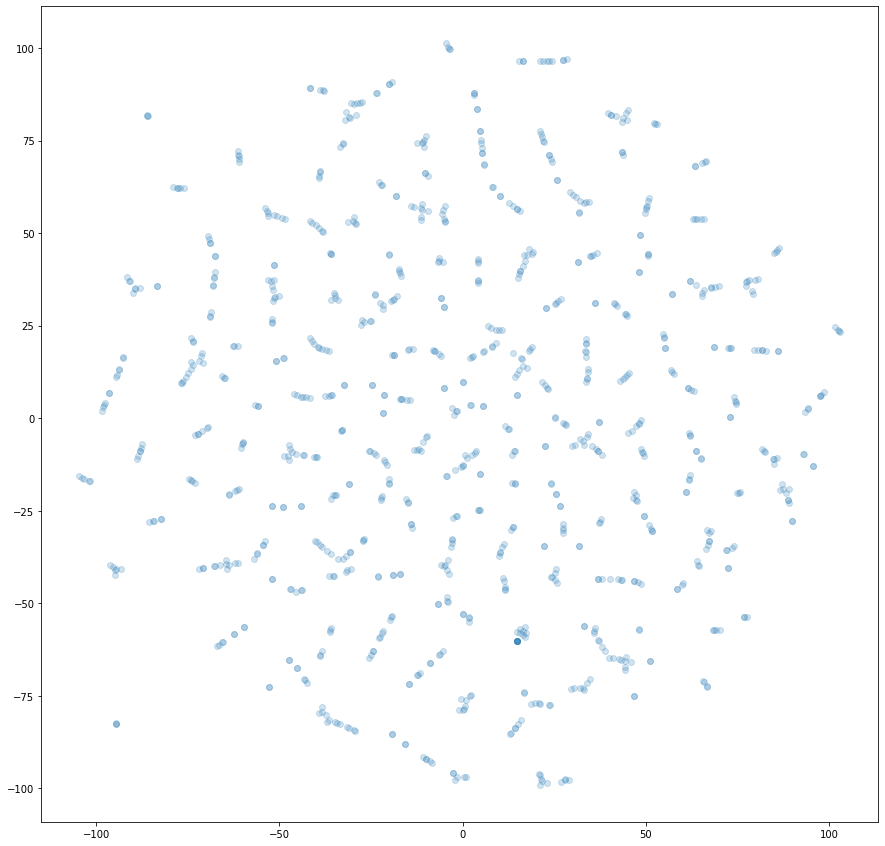

In [ ]:
# Graficamos un TSNE
idx = np.arange(len(corpus))
plt.figure(figsize=(15, 15))
n_docs = 100
idx = np.arange(len(corpus))
valid_idx = np.random.choice(idx, replace=False, size=n_docs)
plt.scatter(T[:, 0], T[:, 1], alpha=0.2)

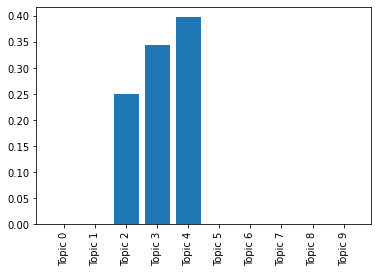

In [ ]:
# Los topicos mas relevantes dentro de un documento
fig, ax = plt.subplots()
Article = 2
ax.bar([f"Topic {i}" for i in range(topics)], np.abs(X_topics[Article]))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [ ]:
# Visualizamos lo topicos encontrados
pyLDAvis.enable_notebook()
LDAvis_data_filepath = "./ldavis_prepared"

In [ ]:
X_bow = bow.transform(norm_corpus)
LDAvis_prepared = sklearn_lda.prepare(lda, X_bow, bow)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
with open(LDAvis_data_filepath,"rb") as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, "./ldavis_prepared.html")
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.121087  0.016306       1        1  27.759304
9     -0.123187  0.003530       2        1  15.426161
3      0.156564  0.052563       3        1  10.074528
2      0.038887  0.092957       4        1   8.752936
0     -0.077100 -0.049582       5        1   8.221951
8      0.035705  0.031726       6        1   7.631527
6     -0.055213 -0.028407       7        1   6.725053
1      0.089654  0.079739       8        1   6.286882
7     -0.081575 -0.019193       9        1   5.795060
5      0.137352 -0.179637      10        1   3.326598, topic_info=              Term        Freq       Total Category  logprob  loglift
12328     sediment  436.000000  436.000000  Default  30.0000  30.0000
4389        energy  244.000000  244.000000  Default  29.0000  29.0000
14296      tsunami  158.000000  158.000000  Default  28.0000  28.0000
1807        carbon  190.000000  190.000000  Default  27.0000  27.0000
12251          sea  538.000000  538.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
3598   development   13.248454  387.335990  Topic10  -5.9667   0.0278
3211          data   13.624011  490.224509  Topic10  -5.9387  -0.1798
14973       waters   11.712762  217.374161  Topic10  -6.0899   0.4823
3668     different   10.467834  314.969417  Topic10  -6.2023  -0.0009
14339          two   10.139596  156.450070  Topic10  -6.2341   0.6669

[763 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
21         4  0.809328    abrasion
32         7  0.715763  absorption
32         9  0.238588  absorption
60         1  0.175682      access
60         3  0.035136      access
...      ...       ...         ...
15324      4  0.067450       zones
15324      6  0.038543       zones
15324      7  0.211986       zones
15324      8  0.077086       zones
15324     10  0.077086       zones

[2287 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 10, 4, 3, 1, 9, 7, 2, 8, 6])

En este **Mapa de Distancia Intertópicos** es posible observar 3 clúster bien definidos:

1. Un grupo de tópicos localizado a la izquierda del mapa y conformado por 5 tópicos; tópico 1, cuyas palabras más frecuentes son: clima, cambio, gestión, ecosistemas e impacto; tópico 2, con palabras frecuentes como: ambiente, contaminación, microplásticos; tópico 9, relacionado con las palabras: pesquerías, peces e hidrocarburos; tópico 5, cuyas palabras más frecuentes son: sensores, satélite, monitoreo y sgd; y tópico 7, con palabras frecuentes como: servicios ecosistémicos, reclamación, Antártica y degradación.

2. Otro grupo localizado a la derecha superior y conformado por 4 tópicos: tópico 4,  relacionado con: energía, marina, corrientes, mareas, olas, clima y viento; tópico 8, con palabras como: surgencia (upwelling), nutrientes, producción, plataforma y temperatura; tópico 6, cuyas palabras más frecuentes son: carbono, azul, orgánico, sedimento, turbas y enterramiento; y tópico 3, relacionado con las palabras: tsuanmi, nivel del mar, sedimentos, línea de costa y evolución.

3. El último grupo conformado por el tópico 10 donde las palabras más frecuentes son: subducción, continental, tectónica, corteza y magmatismo.

## 6. Evaluacion
---

Se evaluó el modelo implementado por medio de la métrica de **perplejidad** utilizando un conjunto de entrenamiento (0.75) y de evaluación (0.25). Dicha métrica, decrese de forma monotónica al aumentar la verosimilitud geométrica media de la palabra en el documento, es decir es inversamente proporcional, por lo que un **valor bajo** de perplejidad indica una mejor desempeño en la generalización del modelo. 


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X_bow, random_state=0, shuffle=True)
# Entrenamos el modelo
topics = 10
lda_train = training(X_train, topics)
lda_train

LatentDirichletAllocation(n_jobs=-1, random_state=0)

In [ ]:
def evaluate(model, data):
    perplexity = model.perplexity(data)
    return perplexity 

In [ ]:
perplexity_list = []
for n_topic in range(1, 30):
  lda_trained = training(X_train, n_topic)
  perplexity_list.append(evaluate(lda_trained, X_test))

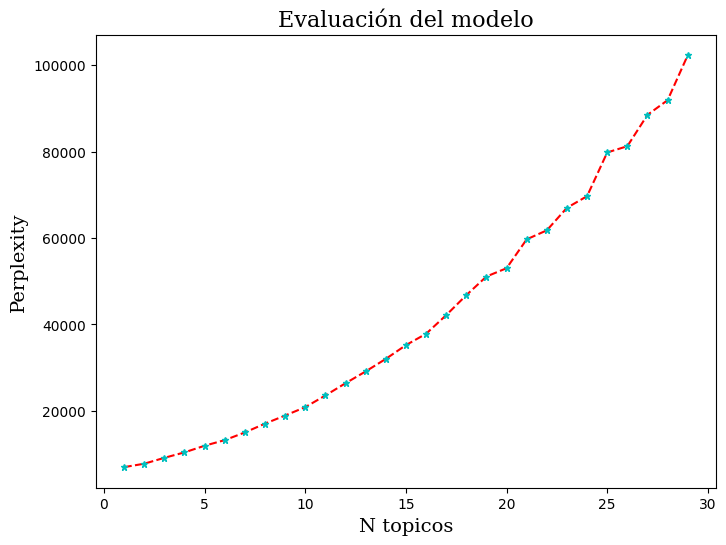

In [ ]:

plt.figure(dpi = 100, figsize = (8, 6))
plt.title('Evaluación del modelo', 
          fontdict= dict(family ='serif', size = 16))
plt.xlabel('N topicos',
           fontdict= dict(family ='serif', size = 14))
plt.ylabel('Perplexity',
           fontdict= dict(family ='serif', size = 14)) 
topic_num_list = [i for i in range(1, 30)]  
plt.plot(topic_num_list, perplexity_list, '--r')
plt.plot(topic_num_list, perplexity_list, 'c*', ms = 5)   
plt.show()

Se avaluó con dicha técnica múltiples modelos de tópicos para determinar el mejor hiperparámetro (número de tópicos) que permitiera obtener un valor bajo de perplejidad. Debido al comportamiento de la curva se define el "criterio del codo" para determinar el hiperparármetro necesario. En este caso, se define como 10 el mejor número de tópicos dado que en este punto se observa una inflexión considerable en el cambio de pendiente de la curva.

## 7. Discusión
---

Analizando los datos representados con el **Mapa de Distancia Intertrópicos** es posible definir tres grandes grupos de tópicos. Dichos grupos representarían los temas más relevantes dentro de la oceanografía de costas.

En primer lugar, se observa un clúster de tópicos en la región derecha del diagrama, como se detalló antes, presenta palabras relacionadas con temas ecológicos y ambientales. Dentro de este clúster, se presentan los tópicos más relevantes para el *corpus*, es decir, los tópicos más importantes dentro de los procesos costeros (cambio climático y contaminación). Sin embargo, ambos tópicos se solapan completamente, por lo que sería posible hablar solo de un tópico (cambio climático), dado que la contaminación hace parte del mismo.

En segundo lugar, en el costado superior derecho se observa un clúster con tópicos muy relacionados entre sí, como: carbono, energías renovables, carbono azul y tsunamis. Por lo que es posible que dicho clúster se relacione con procesos físicos, aplicados a las necesidades económicas y a la gestión del riesgo global.

Finalmente, se observa un tópico muy alejado del resto, este presenta mayormente palabras relacionadas con procesos geodinámicos y tectónicos. Adicionalmente, respecto al tamaño del mismo, este tópico no parece ser de los más relevantes.

Respecto al apartado de evaluación del modelo, se encuentra que uno de los puntos de inflexión de la curva se posiciona en 10 tópicos. Sin embargo, la diferencia en entre elegir 9, 10 u 11 tópicos, no provoca grandes cambios en el modelo.

## 8. Conclusiones
---

Finalmente, podemos concluir que los 10 tópicos más relevantes dentro del campo de los procesos costeros u oceanografía de costas son de tres tipos:

1. Los tópicos más relevantes son los relacionados con el cambio climático y contaminación.

2. Los tópicos con una relevancia media son los relacionados con procesos físicos en las regiones costeras, como: tsunamis, energías renovables, etc.

3. El tópico menos relevante en el campo de los procesos costeros es el relacionado con tectónica de placas y la subducción.